# Background

In [411]:
#!pip install yfinance

In [412]:
from dateutil.relativedelta import relativedelta
import datetime
import requests
import numpy as np
import pandas as pd
import yfinance as yf

In [413]:
def Risk_Free_Rate(Risk_Free):
  Risk_Free = Risk_Free.rename(columns = {"Adj Close":"TB"})
  Risk_Free = Risk_Free.reset_index()
  Risk_Free["Date"] = pd.to_datetime(Risk_Free["Date"])
  Risk_Free["TB"] = pd.to_numeric(Risk_Free["TB"])
  Risk_Free["Risk-Free Return"] = Risk_Free["TB"]/100
  Risk_Free = Risk_Free.dropna()
  Risk_Free = Risk_Free[["Date", "TB", "Risk-Free Return"]]
  return Risk_Free

In [414]:
#Creat a function to calucalte stock/market return caompare value with previuos one
def Return_Rate(x,y,z):
  x = x.rename(columns = {"Adj Close": y})
  x["Date"] = pd.to_datetime(x["Date"])
  x[y] = pd.to_numeric(x[y])
  x["REF"] = x[y].shift(periods=1)
  x[z] = (x[y]-x["REF"])/x["REF"]
  x = x.dropna()
  x = x[["Date",y,"REF", z]]
  return x

In [415]:
# Create a function to calculate the market/stock premium
# by taking the market/stock return and subtracting the risk free return
# Manipulating the data to fit our format by renaming columns
def Premium_with_risk_free(x, y, z, a):
  x = pd.merge(y, Risk_Free, on = "Date")
  x[z] = x[a]- x["Risk-Free Return"]
  x[z] = pd.to_numeric(x[z])
  x["Compound Rate_0"] = (1+x[z])
  x["Compound Rate"] = x["Compound Rate_0"].cumprod()
  x["Investment"] = 1000*["Compound Rate"]
  x = x[["Date", "Risk-Free Return", z, "Compound Rate_0","Compound Rate", "Investment"]]
  x = x.rename(columns = {"Date_y":"Date"})
  return x

In [416]:
def Premium(x, y, z, a):
  x = pd.merge(y, Risk_Free, on = "Date")
  x[z] = x[a]
  x[z] = pd.to_numeric(x[z])
  x["Compound Rate_0"] = (1+x[z])
  x["Compound Rate"] = x["Compound Rate_0"].cumprod()
  x["Compound Rate"] = pd.to_numeric(x["Compound Rate"])

  x = x[["Date", z, "Compound Rate"]]
  x = x.rename(columns = {"Date_y":"Date"})
  return x

In [417]:
def Compound_Rate(asset_name):
    asset_data = yf.download(asset_name, start=Startdate, end=Enddate, interval='1mo')
    asset_data.insert(0, "Index", range(1, 1 + len(asset_data)))
    asset_data = asset_data.reset_index(drop=False)
    asset_data = Return_Rate(asset_data, "Stock Value", asset_name + " Return")
    asset_data = Premium(asset_name + '_Premium', asset_data, asset_name + ' Premium', asset_name + ' Return')
    asset_data['Invetsment'] = asset_data["Compound Rate"] * 1000
    return asset_data

# Data Input

In [418]:
#History Data Time Frame
Startdate = "2014-01-01"
Enddate = "2024-04-02"

Startdate = pd.to_datetime(Startdate)
Enddate = pd.to_datetime(Enddate)

# Risk-free Rate

In [419]:
import yfinance as yf

# Define the ticker symbols for Treasury bonds
tickers = ["^IRX", "^FVX", "^TNX", "^TYX"]  # 6-month T-bill, 5-year, 10-year, 30-year

# Fetch data
Risk_Free_Rate = yf.download(tickers, start=Startdate, end=Enddate, interval="1mo")

# Filter only 'Adj Close' columns
adj_close_columns = [col for col in Risk_Free_Rate.columns if 'Adj Close' in col]
Risk_Free_Rate_adj_close = Risk_Free_Rate[adj_close_columns]

# Clean column names
Risk_Free_Rate_adj_close.columns = [col[1] for col in Risk_Free_Rate_adj_close.columns]
Risk_Free_Rate = Risk_Free_Rate_adj_close.reset_index()
print('Column names cleaned and DataFrame reset.')

[*********************100%%**********************]  4 of 4 completed

Column names cleaned and DataFrame reset.


In [420]:
Risk_Free_Rate = Risk_Free_Rate.rename(columns = {"^IRX": "TB13W", "^FVX": "TB5", "^TNX": "TB10", "^TYX": "TB30"})
Risk_Free_Rate["Date"] = pd.to_datetime(Risk_Free_Rate["Date"])
Risk_Free_Rate.iloc[:, 1:] = Risk_Free_Rate.iloc[:, 1:]/100

In [421]:
Risk_Free_Rate.head()

,Date,TB5,TB13W,TB10,TB30
0,2014-01-01,0.01510,0.00010,0.02668,0.03622
1,2014-02-01,0.01511,0.00043,0.02658,0.03592
2,2014-03-01,0.01732,0.00028,0.02723,0.03561
3,2014-04-01,0.01681,0.00020,0.02648,0.03458
4,2014-05-01,0.01528,0.00030,0.02457,0.03314


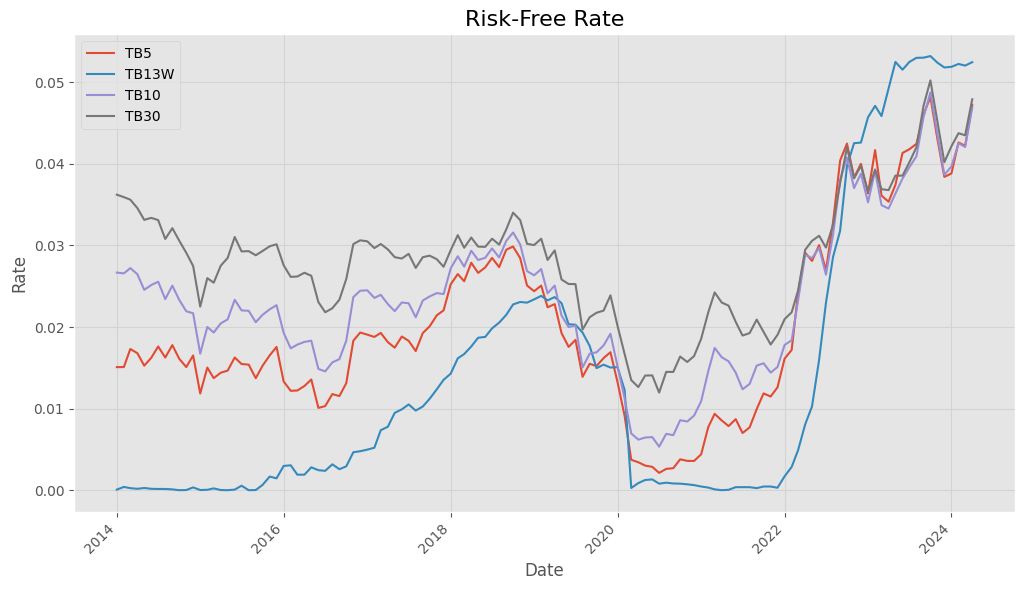

In [422]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12, 6)

for bond in Risk_Free_Rate.iloc[:, 1:].columns:
    axes.plot(Risk_Free_Rate["Date"], Risk_Free_Rate[bond], label=bond)

axes.set(title="Risk-Free Rate", xlabel="Date", ylabel="Rate")
axes.title.set_size(16)
plt.grid(color="lightgray")
fig.autofmt_xdate(rotation=45)  # format x-axis as date, rotate 45 degrees
# axes.set_facecolor('black') #make background behind grid whiteaxes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
fig.tight_layout()  # use tight layout
axes.legend(loc=2)  # move legend to upper left
fig.subplots_adjust(right=0.85)  # adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color="lightgray")
plt.show()

# Index

In [423]:
import yfinance as yf

# Define the ticker symbols for Treasury bonds
tickers = ["^IXIC", "^DJI", "^GSPC"]  # NASDAQ, Dow Jones, S%P 500

# Fetch data
Index = yf.download(tickers, start=Startdate - pd.DateOffset(months=1), end=Enddate, interval="1mo")

# Filter only 'Adj Close' columns
adj_close_columns = [col for col in Index.columns if 'Adj Close' in col]
Index_adj_close = Index[adj_close_columns]

# Clean column names
Index_adj_close.columns = [col[1] for col in Index_adj_close.columns]
Index = Index_adj_close.reset_index()
print('Column names cleaned and DataFrame reset.')

[*********************100%%**********************]  3 of 3 completed

Column names cleaned and DataFrame reset.


In [424]:
Index = Index.rename(columns = {"^IXIC": "NASDAQ", "^DJI":"Dow Jones", "^GSPC":"S&P 500"})
Index["Date"] = pd.to_datetime(Index["Date"])
Index.iloc[:, 1:] = Index.iloc[:, 1:].apply(lambda x: pd.to_numeric(x, errors='coerce').pct_change().replace(np.nan, 0).replace(np.inf, ""), axis=0)
Index = Index.dropna()

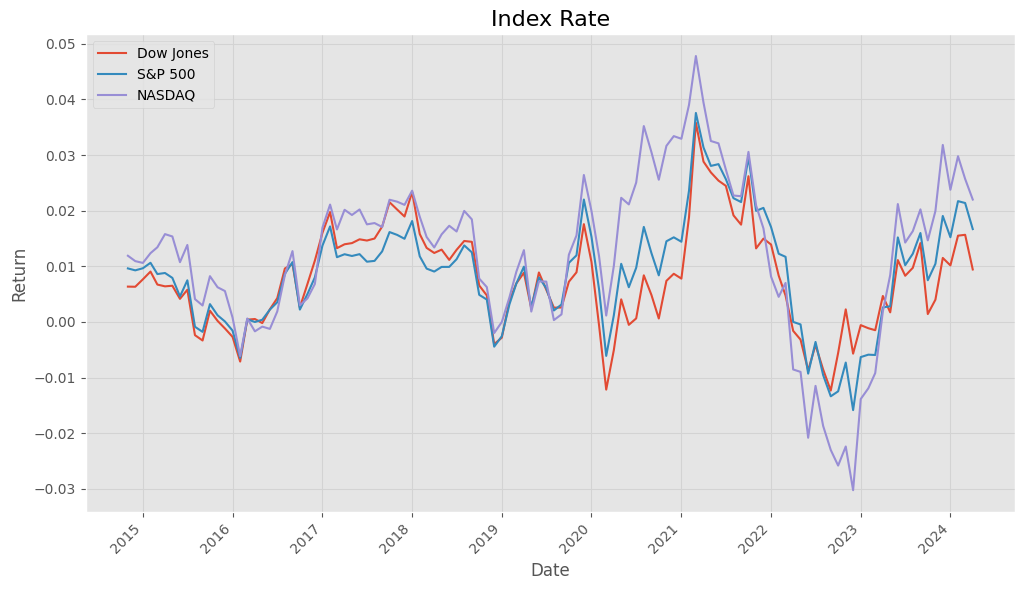

In [425]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12, 6)

Moving = 12

for index in Index.iloc[:, 1:].columns:
    axes.plot(Index["Date"], Index[index].rolling(Moving).mean(), label=index)

axes.set(title="Index Rate", xlabel="Date", ylabel="Return")
axes.title.set_size(16)
plt.grid(color="lightgray")
fig.autofmt_xdate(rotation=45)  # format x-axis as date, rotate 45 degrees
# axes.set_facecolor('black') #make background behind grid whiteaxes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
fig.tight_layout()  # use tight layout
axes.legend(loc=2)  # move legend to upper left
fig.subplots_adjust(right=0.85)  # adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color="lightgray")
plt.show()

In [426]:
Index_Investment = Index.copy()
Index_Investment.iloc[:, 1:] = Index_Investment.iloc[:, 1:].apply(lambda x: (1+x).cumprod()*1000)

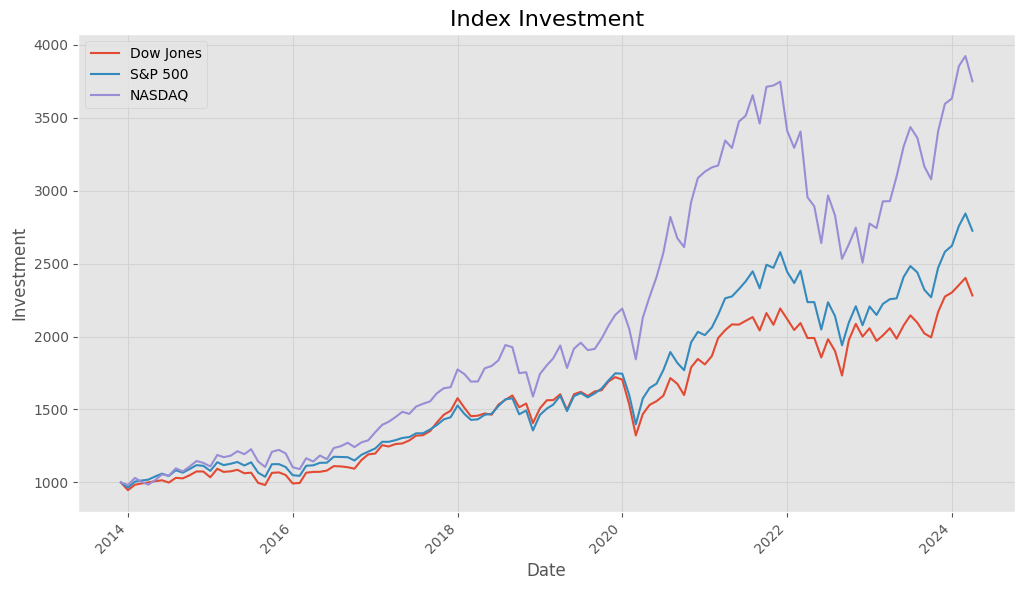

In [427]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12, 6)

for index in Index_Investment.iloc[:, 1:].columns:
    axes.plot(Index_Investment["Date"], Index_Investment[index], label=index)

axes.set(title="Index Investment", xlabel="Date", ylabel="Investment")
axes.title.set_size(16)
plt.grid(color="lightgray")
fig.autofmt_xdate(rotation=45)  # format x-axis as date, rotate 45 degrees
# axes.set_facecolor('black') #make background behind grid whiteaxes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
fig.tight_layout()  # use tight layout
axes.legend(loc=2)  # move legend to upper left
fig.subplots_adjust(right=0.85)  # adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color="lightgray")
plt.show()

# Stock/ETF

## Stock Return without Highlight

In [439]:
import yfinance as yf

# Define the ticker symbols

tickers = ["XOM", "AAPL", "CVS", "JPM", "MNST", "AMZN", "TSLA"]

# Fetch date
Stock = yf.download(tickers, start=Startdate - pd.DateOffset(months=1), end=Enddate, interval="1mo")

# Filter only 'Adj Close' columns
adj_close_columns = [col for col in Stock.columns if 'Adj Close' in col]
Stock_adj_close = Stock[adj_close_columns]

# Clean column names
Stock_adj_close.columns = [col[1] for col in Stock_adj_close.columns]
Stock = Stock_adj_close.reset_index()
Stock = Stock.fillna("")
print('\nColumn names cleaned and DataFrame reset.')


[*********************100%%**********************]  7 of 7 completed


Column names cleaned and DataFrame reset.


In [440]:
Stock["Date"] = pd.to_datetime(Stock["Date"])
Stock.iloc[:, 1:] = Stock.iloc[:, 1:].apply(lambda x: pd.to_numeric(x, errors='coerce').pct_change().replace(np.nan, 0).replace(np.inf, ""), axis=0)
Stock = Stock[1:]

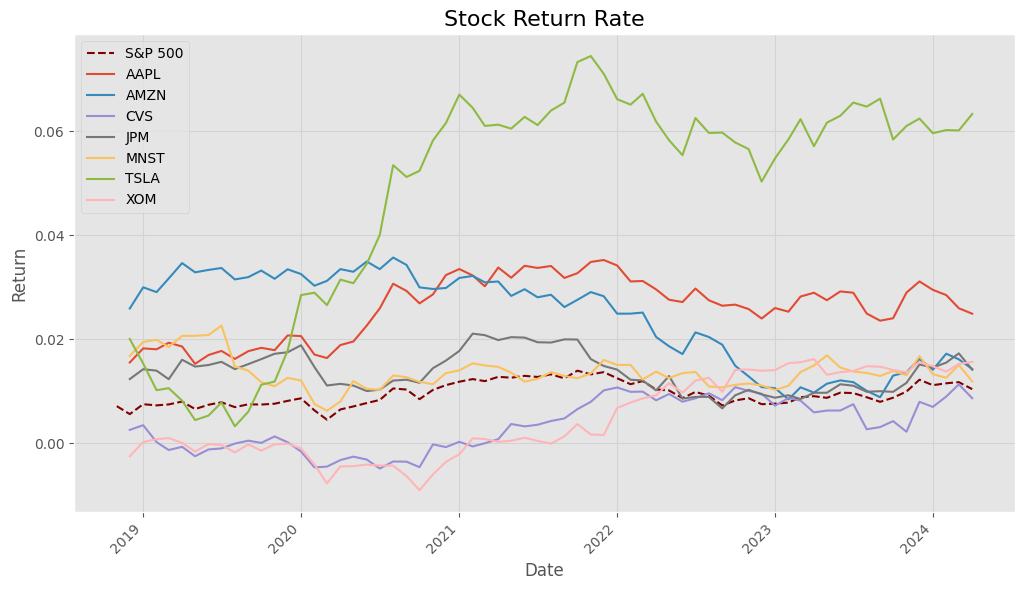

In [441]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12, 6)

Moving = 60

#Change to other Index if Needed
axes.plot(Index["Date"], Index["S&P 500"].rolling(Moving).mean(), label="S&P 500", color = "maroon", linestyle="--")

for stock in Stock.iloc[:, 1:].columns:
    axes.plot(Stock["Date"], Stock[stock].rolling(Moving).mean(), label=stock)

axes.set(title="Stock Return Rate", xlabel="Date", ylabel="Return")
axes.title.set_size(16)
plt.grid(color="lightgray")
fig.autofmt_xdate(rotation=45)  # format x-axis as date, rotate 45 degrees
# axes.set_facecolor('black') #make background behind grid whiteaxes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
fig.tight_layout()  # use tight layout
axes.legend(loc=2)  # move legend to upper left
fig.subplots_adjust(right=0.85)  # adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color="lightgray")
plt.show()

In [442]:
Stock_Investment = Stock.copy()
Stock_Investment.iloc[:, 1:] = Stock_Investment.iloc[:, 1:].apply(lambda x: (1+x).cumprod()*1000)

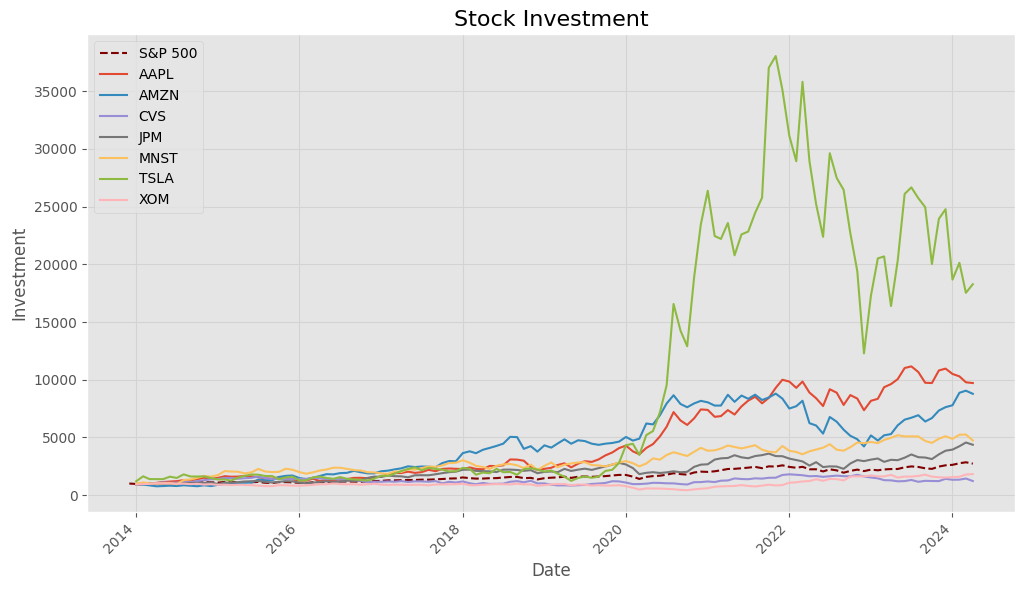

In [443]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12, 6)

#Change to other Index if Needed
axes.plot(Index_Investment["Date"], Index_Investment["S&P 500"], label="S&P 500", color = "maroon", linestyle="--")

for stock in Stock_Investment.iloc[:, 1:].columns:
    axes.plot(Stock_Investment["Date"], Stock_Investment[stock], label=stock)

axes.set(title="Stock Investment", xlabel="Date", ylabel="Investment")
axes.title.set_size(16)
plt.grid(color="lightgray")
fig.autofmt_xdate(rotation=45)  # format x-axis as date, rotate 45 degrees
# axes.set_facecolor('black') #make background behind grid whiteaxes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
fig.tight_layout()  # use tight layout
axes.legend(loc=2)  # move legend to upper left
fig.subplots_adjust(right=0.85)  # adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color="lightgray")
plt.show()

## Stock/Return With Highlight

In [444]:
# Define the ticker symbols
tickers_to_highlight = ["AMZN", "TSLA"]

tickers_no_hightlight = ["XOM","AAPL", "CVS", "JPM", "MNST"]

In [451]:
import yfinance as yf

# Fetch date
Stock_to_highlight = yf.download(tickers_to_highlight, start=Startdate - pd.DateOffset(months=1), end=Enddate, interval="1mo")
Stock_no_highlight = yf.download(tickers_no_hightlight, start=Startdate - pd.DateOffset(months=1), end=Enddate, interval="1mo")

# Filter only 'Adj Close' columns
adj_close_columns = [col for col in Stock_to_highlight.columns if 'Adj Close' in col]
Stock_to_highlight_adj_close = Stock_to_highlight[adj_close_columns]

# Clean column names
Stock_to_highlight_adj_close.columns = [col[1] for col in Stock_to_highlight_adj_close.columns]
Stock_to_highlight = Stock_to_highlight_adj_close.reset_index()
Stock_to_highlight = Stock_to_highlight.fillna("")
print('\nColumn names cleaned and DataFrame reset.')

# Filter only 'Adj Close' columns
adj_close_columns = [col for col in Stock_no_highlight.columns if 'Adj Close' in col]
Stock_no_highlight_adj_close = Stock_no_highlight[adj_close_columns]

# Clean column names
Stock_no_highlight_adj_close.columns = [col[1] for col in Stock_no_highlight_adj_close.columns]
Stock_no_highlight = Stock_no_highlight_adj_close.reset_index()
Stock_no_highlight = Stock_no_highlight.fillna("")
print('Column names cleaned and DataFrame reset.')


[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  5 of 5 completed



Column names cleaned and DataFrame reset.
Column names cleaned and DataFrame reset.


In [446]:
Stock_to_highlight["Date"] = pd.to_datetime(Stock_to_highlight["Date"])
Stock_to_highlight.iloc[:, 1:] = Stock_to_highlight.iloc[:, 1:].apply(lambda x: pd.to_numeric(x, errors='coerce').pct_change().replace(np.nan, 0).replace(np.inf, ""), axis=0)
Stock_to_highlight = Stock_to_highlight[1:]
Stock_no_highlight["Date"] = pd.to_datetime(Stock_no_highlight["Date"])
Stock_no_highlight.iloc[:, 1:] = Stock_no_highlight.iloc[:, 1:].apply(lambda x: pd.to_numeric(x, errors='coerce').pct_change().replace(np.nan, 0).replace(np.inf, ""), axis=0)
Stock_no_highlight = Stock_no_highlight[1:]

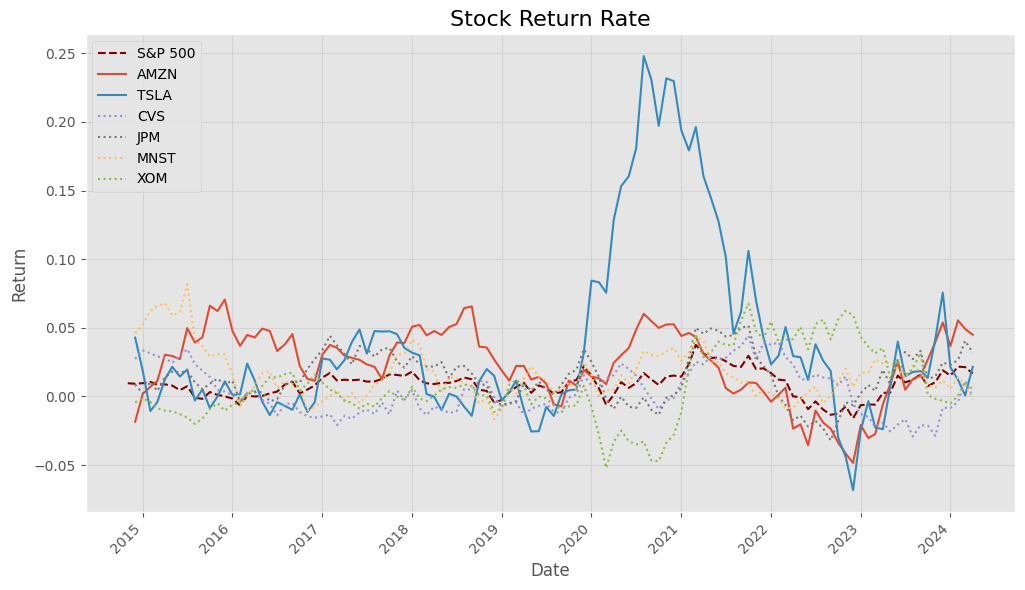

In [447]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12, 6)

Moving = 12

# Plot S&P 500 with dashed line
axes.plot(Index["Date"], Index["S&P 500"].rolling(Moving).mean(), label="S&P 500", color="maroon", linestyle="--")

# Plot highlighted stocks
for stock in Stock_to_highlight.iloc[:, 1:].columns:
    axes.plot(Stock_to_highlight["Date"], Stock_to_highlight[stock].rolling(Moving).mean(), label=stock)

# Plot other stocks
for stock in Stock_no_highlight_adj_close.iloc[:, 1:].columns:
    axes.plot(Stock_no_highlight["Date"], Stock_no_highlight[stock].rolling(Moving).mean(), label=stock, linestyle=":"),#color=(0.8, 0.8, 0.8))

axes.set(title="Stock Return Rate", xlabel="Date", ylabel="Return")
axes.title.set_size(16)
plt.grid(color="lightgray")
fig.autofmt_xdate(rotation=45)  # format x-axis as date, rotate 45 degrees
fig.tight_layout()  # use tight layout
axes.legend(loc="upper left")  # move legend to upper left
fig.subplots_adjust(right=0.85)  # adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color="lightgray")
plt.show()


In [448]:
Stock_to_highlight_Investment = Stock_to_highlight.copy()
Stock_to_highlight_Investment.iloc[:, 1:] = Stock_to_highlight_Investment.iloc[:, 1:].apply(lambda x: (1+x).cumprod()*1000)
Stock_no_highlight_Investment = Stock_no_highlight.copy()
Stock_no_highlight_Investment.iloc[:, 1:] = Stock_no_highlight_Investment.iloc[:, 1:].apply(lambda x: (1+x).cumprod()*1000)

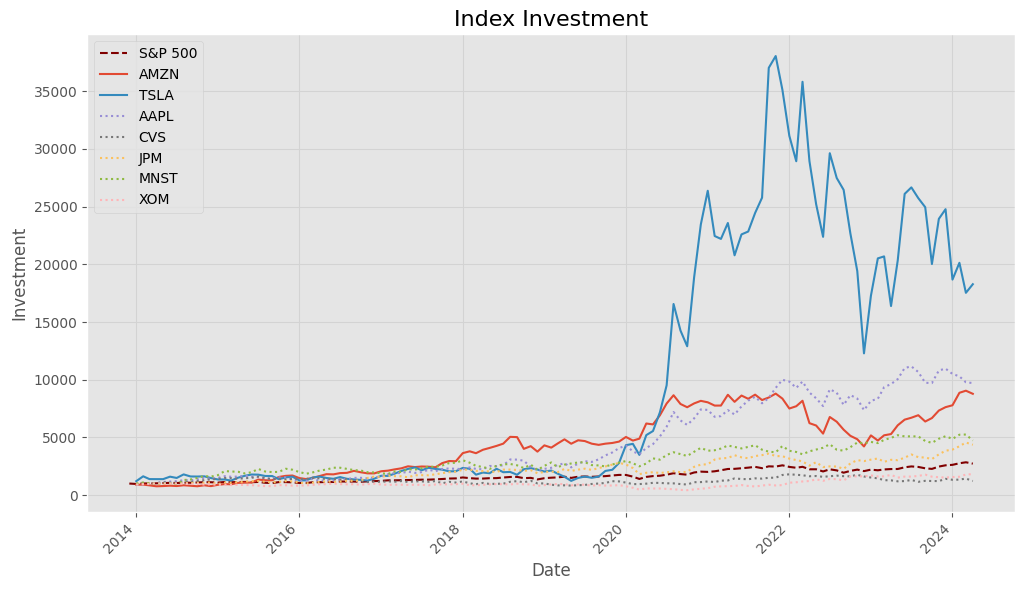

In [449]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12, 6)

#Change to other Index if Needed
axes.plot(Index_Investment["Date"], Index_Investment["S&P 500"], label="S&P 500", color = "maroon", linestyle="--")

for stock in Stock_to_highlight_Investment.iloc[:, 1:].columns:
    axes.plot(Stock_to_highlight_Investment["Date"], Stock_to_highlight_Investment[stock], label=stock)

for stock in Stock_no_highlight_Investment.iloc[:, 1:].columns:
    axes.plot(Stock_no_highlight_Investment["Date"], Stock_no_highlight_Investment[stock], label=stock, linestyle=":")#color=(0.8, 0.8, 0.8))

axes.set(title="Index Investment", xlabel="Date", ylabel="Investment")
axes.title.set_size(16)
plt.grid(color="lightgray")
fig.autofmt_xdate(rotation=45)  # format x-axis as date, rotate 45 degrees
# axes.set_facecolor('black') #make background behind grid whiteaxes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
fig.tight_layout()  # use tight layout
axes.legend(loc=2)  # move legend to upper left
fig.subplots_adjust(right=0.85)  # adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color="lightgray")
plt.show()